### Building evasion vs. mean time interval : by Bus by Service

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from Utils import TransantiagoConstants

In [3]:
first_quarter_path = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/06_RFA/01_EvasionTrimestral/01_analisis/1st_quarter.xlsx"
second_quarter_path = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/06_RFA/01_EvasionTrimestral/01_analisis/2nd_quarter.xlsx"
third_quarter_path = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/06_RFA/01_EvasionTrimestral/01_analisis/3rd_quarter.xlsx"
codes_path = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/04_DTPM/codes_services.xlsx"

In [4]:
first_quarter_evasion = pd.read_excel(first_quarter_path, encoding = 'latin-1')
second_quarter_evasion = pd.read_excel(second_quarter_path, encoding = 'latin-1')
third_quarter_evasion = pd.read_excel(third_quarter_path, encoding = 'latin-1')
codes = pd.read_excel(codes_path, encoding = 'latin-1')

In [5]:
first_quarter_evasion['TIEMPO'] = first_quarter_evasion['HORA'].astype(str)+':'+first_quarter_evasion['MINUTOS'].astype(str)+':00'
second_quarter_evasion['TIEMPO'] = second_quarter_evasion['HORA'].astype(str)+':'+second_quarter_evasion['MINUTOS'].astype(str)+':00'
third_quarter_evasion['TIEMPO'] = third_quarter_evasion['HORA'].astype(str)+':'+third_quarter_evasion['MINUTOS'].astype(str)+':00'

In [6]:
first_quarter_evasion.columns = ['FECHA', 'SERVICIO','PATENTE','PUERTAS','N_PUERTA','LUGAR_INICIO','HORA_INICIO','HORA','MINUTO','INGRESAN','NO_VALIDAN','TP','TIEMPO']
second_quarter_evasion.columns = ['FECHA', 'SERVICIO','TIPO','PATENTE','PUERTAS','N_PUERTA','LUGAR_INICIO','HORA_INICIO','HORA','MINUTO','INGRESAN','NO_VALIDAN','TP','TIEMPO']
third_quarter_evasion.columns = ['FECHA', 'SERVICIO','PATENTE','PUERTAS','N_PUERTA','LUGAR_INICIO','HORA_INICIO','HORA','MINUTO','INGRESAN','NO_VALIDAN','TP','TIEMPO']
del second_quarter_evasion['TIPO']

In [7]:
type(first_quarter_evasion.loc[0,'TIEMPO'])

str

In [8]:
type(first_quarter_evasion.loc[0,'FECHA'])

pandas._libs.tslib.Timestamp

In [9]:
frames = [first_quarter_evasion, second_quarter_evasion, third_quarter_evasion]
evasion = pd.concat(frames, keys=['first', 'second', 'third'])

In [10]:
evasion.loc[:,'SERVICIO'] = evasion.loc[:,'SERVICIO'].apply(str)

* Processing codes before merging. Merge should be made only by codes_ida or codes_ret. Be aware of it

In [11]:
codes_ida = codes[codes['DIRECTION']=='Ida']
codes_ret = codes[codes['DIRECTION']=='Ret']

# Both, USER_CODE and TS_CODE should be strings, in both codes_ida and codes_ret.
codes_ida.loc[:,'USER_CODE'] = codes_ida.loc[:,'USER_CODE'].apply(str)
codes_ida.loc[:,'TS_CODE'] = codes_ida.loc[:,'TS_CODE'].apply(str)

codes_ret.loc[:,'USER_CODE'] = codes_ret.loc[:,'USER_CODE'].apply(str)
codes_ret.loc[:,'TS_CODE'] = codes_ret.loc[:,'TS_CODE'].apply(str)

del codes_ida['DIRECTION']
del codes_ret['DIRECTION']


#Cleaning codes from special services. Be aware of this since it might generates errors in the final merging with trx database.
clean_codes_ida = codes_ida[(~codes_ida["TS_CODE"].str.contains('y'))&(~codes_ida["TS_CODE"].str.contains('Y'))]
clean_codes_ret = codes_ida[(~codes_ida["TS_CODE"].str.contains('y'))&(~codes_ida["TS_CODE"].str.contains('Y'))]

clean_codes_ida = clean_codes_ida.rename(columns = {'USER_CODE':'SERVICIO'})
clean_codes_ret = clean_codes_ret.rename(columns = {'USER_CODE':'SERVICIO'})

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
evasion = pd.merge(evasion,clean_codes_ida, on=['SERVICIO'], how='left')

In [13]:
evasion.loc[evasion['TS_CODE'].isnull(),'SERVICIO'].unique()

array(['D06'], dtype=object)

* THIS IS HARDCODED

In [14]:
evasion.loc[evasion['TS_CODE'].isnull(),'TS_CODE']='446'

In [15]:
evasion.head()

,FECHA,SERVICIO,PATENTE,PUERTAS,N_PUERTA,LUGAR_INICIO,HORA_INICIO,HORA,MINUTO,INGRESAN,NO_VALIDAN,TP,TIEMPO,UN,TS_CODE
0,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,10,15,1,P,7:10:00,2.0,214
1,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,12,9,0,P,7:12:00,2.0,214
2,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,13,6,2,P,7:13:00,2.0,214
3,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,18,8,1,P,7:18:00,2.0,214
4,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,20,5,1,P,7:20:00,2.0,214


* Processing evasion-ddbb before merging

In [16]:
evasion['PATENTE'] =  evasion['PATENTE'].str.replace(' ','')

evasion.loc[:,'TS_CODE'] = evasion.loc[:,'TS_CODE'].apply(str)

evasion = evasion.rename(columns = {'SERVICIO':'SERVICIO_USUARIO', 'TS_CODE':'SERVICIO'})

evasion_paradero = evasion[evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

In [17]:
type(evasion['SERVICIO'][0])

str

* Getting evasion by bus by service

In [18]:
f = {'SERVICIO':['count'],'INGRESAN':['sum'], 'NO_VALIDAN':['sum']}

summary = evasion_paradero_first.groupby(['FECHA','PATENTE','SERVICIO']).agg(f)
summary.columns=['EVASION_COUNT', 'TOTAL_INGRESAN', 'TOTAL_NO_VALIDAN']
summary.reset_index(inplace=True)

* Building complete etapas ddbb.

In [19]:
common_dates = TransantiagoConstants.common_dates

In [20]:
reduced_etapas = pd.DataFrame()

for date in common_dates:
    base_input_path = 'C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/01_SSH/02_TIMESBYBUSBYSERVICE/02_20SECS/'
    file_name = date + '-meanByBusByService.csv'
    grouped_by_bus = pd.read_csv(base_input_path+file_name, encoding = 'latin-1',sep =";")
    reduced_etapas = pd.concat([reduced_etapas,grouped_by_bus])


* Processing etapas ddbb before merging

In [21]:
del reduced_etapas['Unnamed: 0']
reduced_etapas = reduced_etapas.rename(columns = {'fecha':'FECHA', 'sitio_subida':'PATENTE', 'count': 'ETAPAS_COUNT', 'servicio_subida' : 'SERVICIO'})
reduced_etapas['FECHA'] = pd.to_datetime(reduced_etapas.FECHA)
reduced_etapas['PATENTE'] = reduced_etapas['PATENTE'].str.replace("-", "")
reduced_etapas['PATENTE'] = reduced_etapas['PATENTE'].str.replace(" ", "")

In [22]:
reduced_etapas.reset_index(drop=True,inplace=True)

In [23]:
type(reduced_etapas.loc[0,'FECHA'])

pandas._libs.tslib.Timestamp

* Merging.

In [24]:
evasion_vs_mean = pd.merge(summary,reduced_etapas, on=['PATENTE','SERVICIO','FECHA'], how='left')

In [25]:
len(evasion_vs_mean.index)

1184

* Getting rid of missing values

In [26]:
clean_evasion_vs_mean = evasion_vs_mean[evasion_vs_mean['mean']>0]

In [27]:
len(clean_evasion_vs_mean.index)

481

* Computing evasion rate: should be computed before... a warning is popping up

In [28]:
clean_evasion_vs_mean.loc[:,'EVASION_RATE'] = clean_evasion_vs_mean.loc[:,'TOTAL_NO_VALIDAN'] / clean_evasion_vs_mean.loc[:,'TOTAL_INGRESAN']

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
clean_evasion_vs_mean.loc[:,'fecha_instalacion'] = pd.to_datetime(clean_evasion_vs_mean.loc[:,'fecha_instalacion'])

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
clean_evasion_vs_mean.loc[:,'SI_TORNIQUETE'] = (clean_evasion_vs_mean.loc[:,'fecha_instalacion'].notnull())

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [31]:
clean_evasion_vs_mean.loc[:,'SI_2017_TORNIQUETE'] = (clean_evasion_vs_mean.loc[:,'fecha_instalacion']>pd.to_datetime('2017-01-01'))

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
clean_evasion_vs_mean_no_turnstile = clean_evasion_vs_mean[(clean_evasion_vs_mean['SI_TORNIQUETE']==False) | 
                                                           ((clean_evasion_vs_mean['SI_TORNIQUETE']==True) & (clean_evasion_vs_mean['FECHA']<=clean_evasion_vs_mean['fecha_instalacion']))]

In [33]:
clean_evasion_vs_mean.head()

,FECHA,PATENTE,SERVICIO,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,ETAPAS_COUNT,sum,mean,fecha_instalacion,EVASION_RATE,SI_TORNIQUETE,SI_2017_TORNIQUETE
302,2017-03-09,BKWK90,F05,49,94,27,212.0,618.0,2.915094,NaT,0.287234,False,False
303,2017-03-09,CJJH75,B07,48,125,58,179.0,518.0,2.893855,2017-07-03,0.464000,True,True
304,2017-03-09,CJKC18,B07,38,48,7,37.0,136.0,3.675676,2017-07-05,0.145833,True,True
305,2017-03-09,CJRG61,F05,25,33,18,22.0,95.0,4.318182,NaT,0.545455,False,False
306,2017-03-09,FLXB75,B07,20,62,0,153.0,757.0,4.947712,2016-07-26,0.000000,True,False


In [40]:
type(clean_evasion_vs_mean.loc[302,'fecha_instalacion'])

pandas._libs.tslib.NaTType

In [41]:
type(clean_evasion_vs_mean.loc[303,'fecha_instalacion'])

pandas._libs.tslib.Timestamp

In [34]:
len(clean_evasion_vs_mean_no_turnstile.index)

359

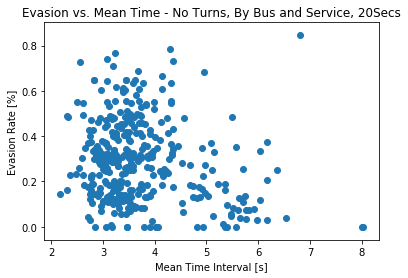

In [35]:
fig_1, ax_1 = plt.subplots()

ax_1.scatter(clean_evasion_vs_mean_no_turnstile['mean'],clean_evasion_vs_mean_no_turnstile['EVASION_RATE'])
ax_1.set_title('Evasion vs. Mean Time - No Turns, By Bus and Service, 20Secs')
ax_1.set_xlabel('Mean Time Interval [s]')
ax_1.set_ylabel('Evasion Rate [%]')

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/8_20Secs_EvasionVsMeanTimeByBusByService.pdf')

In [36]:
clean_evasion_vs_mean_no_turnstile.head()

,FECHA,PATENTE,SERVICIO,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,ETAPAS_COUNT,sum,mean,fecha_instalacion,EVASION_RATE,SI_TORNIQUETE,SI_2017_TORNIQUETE
302,2017-03-09,BKWK90,F05,49,94,27,212.0,618.0,2.915094,NaT,0.287234,False,False
303,2017-03-09,CJJH75,B07,48,125,58,179.0,518.0,2.893855,2017-07-03,0.464000,True,True
304,2017-03-09,CJKC18,B07,38,48,7,37.0,136.0,3.675676,2017-07-05,0.145833,True,True
305,2017-03-09,CJRG61,F05,25,33,18,22.0,95.0,4.318182,NaT,0.545455,False,False
308,2017-03-09,FLXG78,F05,44,79,16,111.0,371.0,3.342342,NaT,0.202532,False,False


In [37]:
print(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].mean())
print(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].max())
print(clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].min())

29.874651810584957
127
3


In [38]:
print(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].mean())
print(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].max())
print(clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].min())

191.9693593314763
815.0
5.0


In [39]:
clean_evasion_vs_mean_no_turnstile[(clean_evasion_vs_mean_no_turnstile['FECHA']==pd.to_datetime('2017-07-19'))&(clean_evasion_vs_mean_no_turnstile['PATENTE']=='CJRZ54')]

,FECHA,PATENTE,SERVICIO,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,ETAPAS_COUNT,sum,mean,fecha_instalacion,EVASION_RATE,SI_TORNIQUETE,SI_2017_TORNIQUETE
917,2017-07-19,CJRZ54,457,7,6,0,85.0,419.0,4.929412,NaT,0.0,False,False


### Closed